In [1]:
import core
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The class UF2 implements the K_j and K_j* operators, which are class methods named "up" and "down" respectively, and can be used to calculate the wavepackets associated with any Feynman diagram.  See below for an example of calculating a single diagram.

The file TA_example.py includes a class, TransientAbsorption, that calculates all of the required diagrams for the transient absorption signal.  An example of using that class is given as well. 

The file TA_isotropic_average_example.py demonstrates how to isotropically average the transient absorption signal.

The file TA_5th_order_example.py shows how to calculate higher-order contributions to the transient absorption signal. This is intended to show how this code can be extended to n-wave mixing processes.

The file TA_5th_order_isotropic_average_example.py shows how to isotropically average a 6-wave mixing process.

In [2]:
UF2 = core.UF2

Here is an example of how to use the algorithm to calculate the SE contribution of a pump-probe experiment.  We begin by specifying the relevant electric field paramters

In [3]:
def pump(t,sigma):
    """Define pump field"""
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-t**2/(2*sigma**2))

def probe(t,sigma):
    """Define the probe field"""
    return 1/np.sqrt(2*np.pi)/sigma*np.exp(-t**2/(2*sigma**2))

In [4]:
# Initialize object by specifying the path to the folder where the eigenvalues and dipole operator are saved
file_path = 'monomer_d0.4/'
dt = 0.1 # Time spacing required to resolve all pulse shapes
M = 138 # number of points required to resolve all pulse shapes
psi0_state = 0 # Initial ground eigenstate that the system begins in
total_t = int(200/dt) # Total number of time points - must span from 0 to 5/gamma beyond last delay time point

uf2 = UF2(file_path,dt=dt,num_conv_points=M,initial_state=psi0_state,total_num_time_points=total_t)

# Define the pump and probe amplitude functions.  Note that both should be defined centered at t = 0

pump_sigma = 0.8 # in units of omega_0^-1
probe_sigma = 1 # in units of omega_0^-1

pu = pump(uf2.efield_t,pump_sigma)
pr = probe(uf2.efield_t,probe_sigma)

# Pump-probe spectroscopy is calculated to lowest order as four-wave mixing
# where the pump provides the first two interactions, and the probe
# provides the third interaction, and acts as the "fourth interaction" in 
# the form of the local oscillator

uf2.efields = [pu,pu,pr,pr]

# The pump is polarized along the 'x' direcetion
# The probe is polarized along the same direction

uf2.set_polarization_sequence(['x','x','x','x'])

# Set gamma - effective optical dephasing rate
uf2.set_homogeneous_linewidth(0.05)

<IPython.core.display.Javascript object>


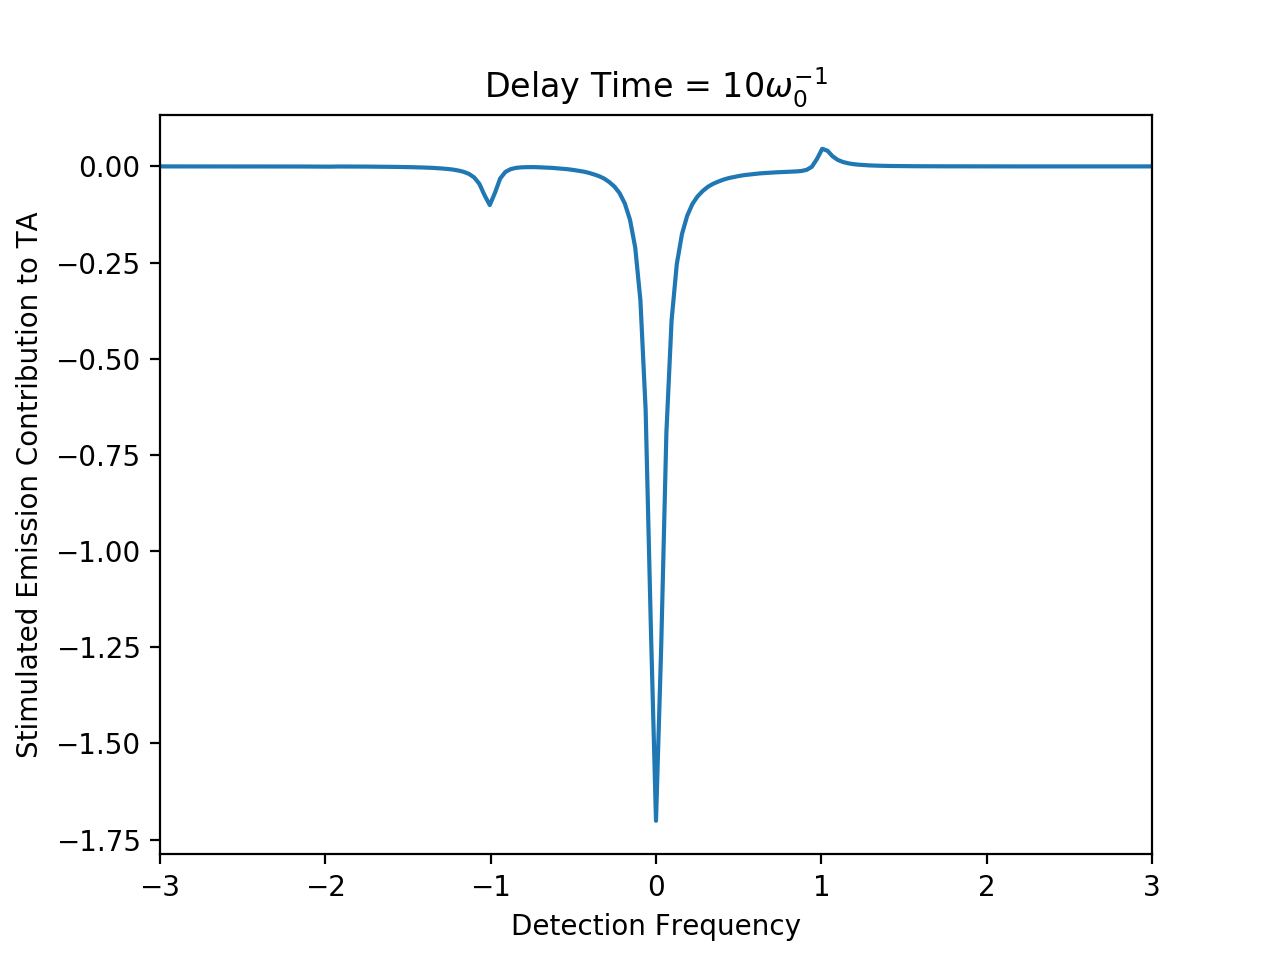

Text(0.5,1,'Delay Time = 10$\\omega_0^{-1}$')

In [5]:
# Create the wavepackets needed for the SE signal at the specified delay time

delay_time = 10

# Using this delay time, set the interaction times for each of the four interactions
# in the form [pump_time, pump_time, probe_time, probe_time]

uf2.pulse_times = [0,0,delay_time,delay_time]

# Construct Perturbative Wavepackets

psi_b = uf2.up(uf2.psi0,pulse_number = 1)
psi_a = uf2.up(uf2.psi0,pulse_number = 0)
psi_ac = uf2.down(psi_a,pulse_number = 2)

# Calculate the SE contribution to the resulting frequency-resolved spectrum at the specified delay time

# The time-dependent polarization field is the expectation value of the perturbed wavepackets and
# the dipole operator

SE_polarization = uf2.dipole_expectation(psi_ac,psi_b)

# Finally convert that polarization into a heterodyne-detected signal

SE_signal = uf2.polarization_to_signal(SE_polarization)

# The frequency-detected signal for this value of delay time is plotted here

plt.figure()
plt.plot(uf2.w,SE_signal)
plt.xlim([-3,3])
plt.xlabel('Detection Frequency')
plt.ylabel('Stimulated Emission Contribution to TA')
plt.title('Delay Time = {}'.format(delay_time) + '$\omega_0^{-1}$')

See the file TA_example.py for an example of how the class WavepacketBuilder can be used to calculate the full transient absorption signal.  See below for the example signal.

In [6]:
import TA_example

In [7]:
pump_sigma = 0.2
probe_sigma = 0.2
dt = min(pump_sigma,probe_sigma)/2
M = 138
total_t = int(200/dt)

<IPython.core.display.Javascript object>


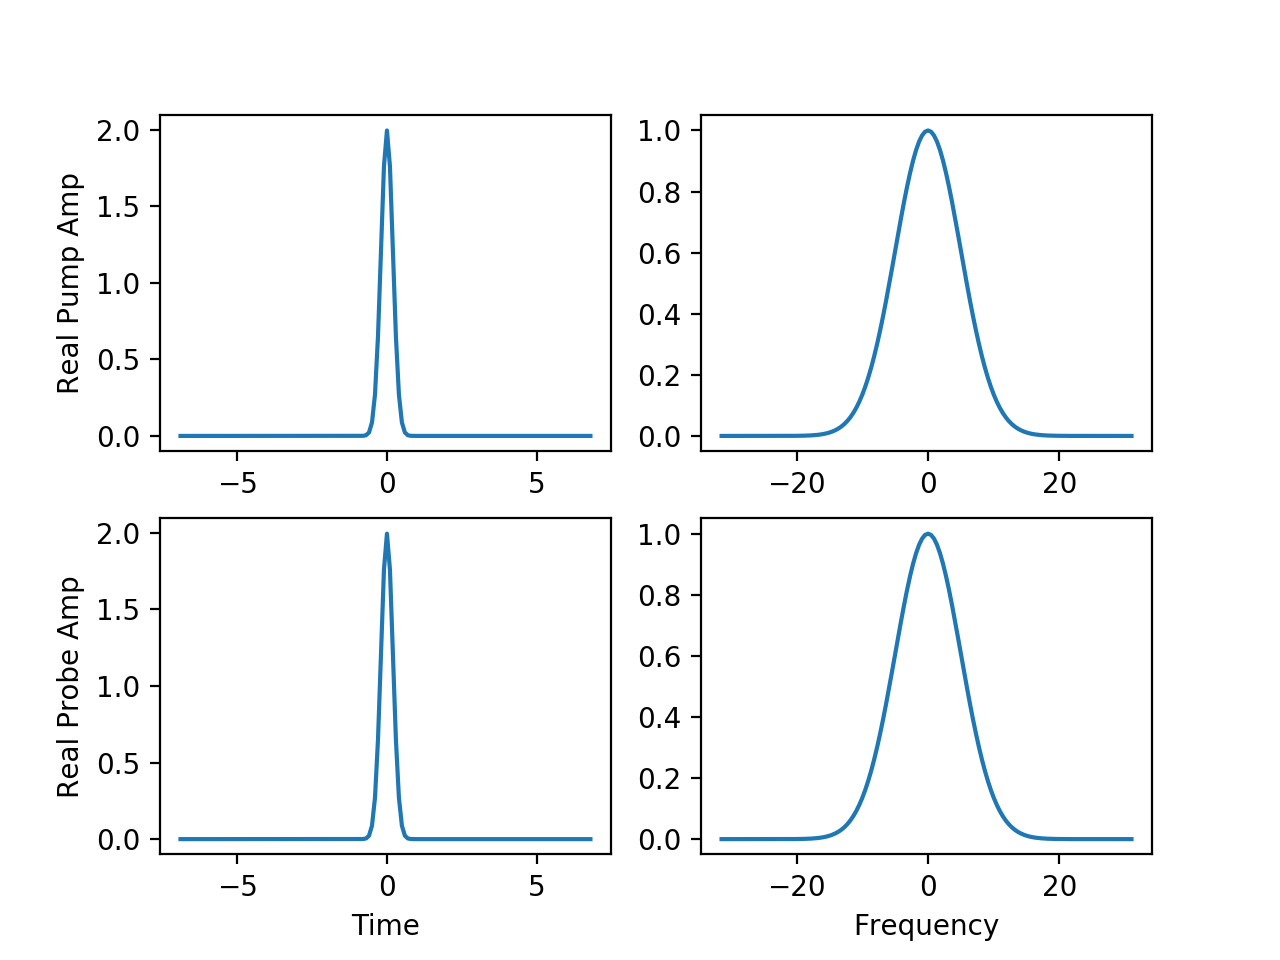

In [8]:
# Initialize object with filepath to saved eigenvalues and dipole operator

TA = reload(TA_example)
ta = TA.TransientAbsorption(file_path,dt=dt,num_conv_points=M,total_num_time_points=total_t)

# As before, signal fields and polarization sequence must be set

pu = pump(ta.efield_t,pump_sigma) #Using above Gaussian field definition
pr = probe(ta.efield_t,probe_sigma) #Using above Gaussian field definition

# The class TransientAbsorption has a method for setting the four interaction fields given the pump shape and the
# probe shape

ta.set_pulse_shapes(pu,pr)

# The pump is polarized along the 'x' direcetion
# The probe is polarized along the same direcetion

pol_seq = ['x','x','x','x']

ta.set_polarization_sequence(pol_seq)

<IPython.core.display.Javascript object>


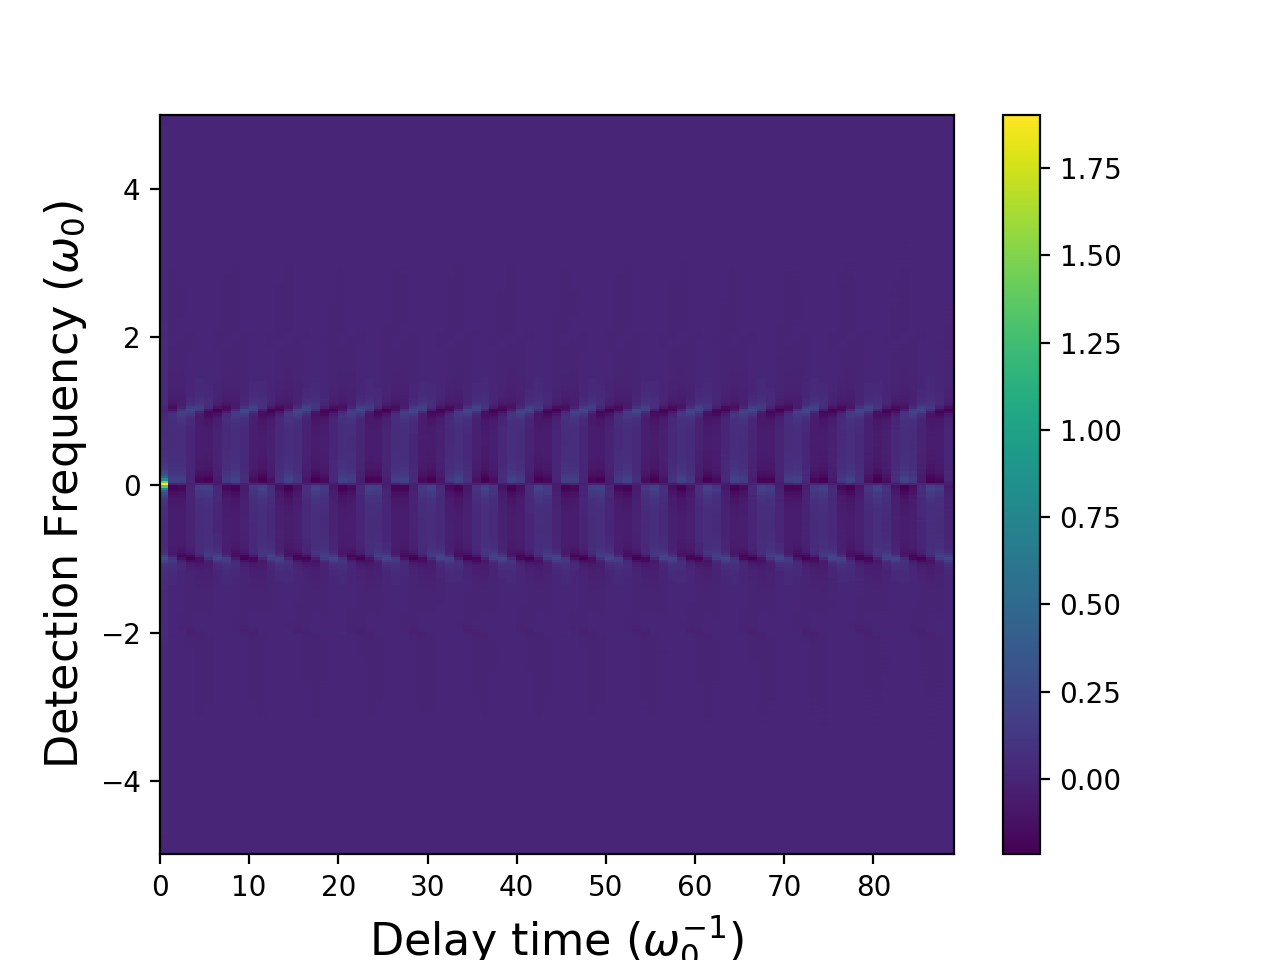

In [9]:
# Pick delay times of interest.  The code is written in such a way that negative delay times cannot be calculated. 
# This is a limitation of the implementation, not of the method
delay_times = np.arange(0,90,1) #delay times must coincide with time mesh calculation is performed on

# The class TransientAbsorption includes all necessary diagrams for calculating the TA signal

spectra = ta.calculate_pump_probe_spectra_vs_delay_time(delay_times)
ta.save_pump_probe_spectra_vs_delay_time()
ta.plot_pump_probe_spectra(frequency_range = [-5,5],subtract_DC=True,save_fig=True)

<IPython.core.display.Javascript object>


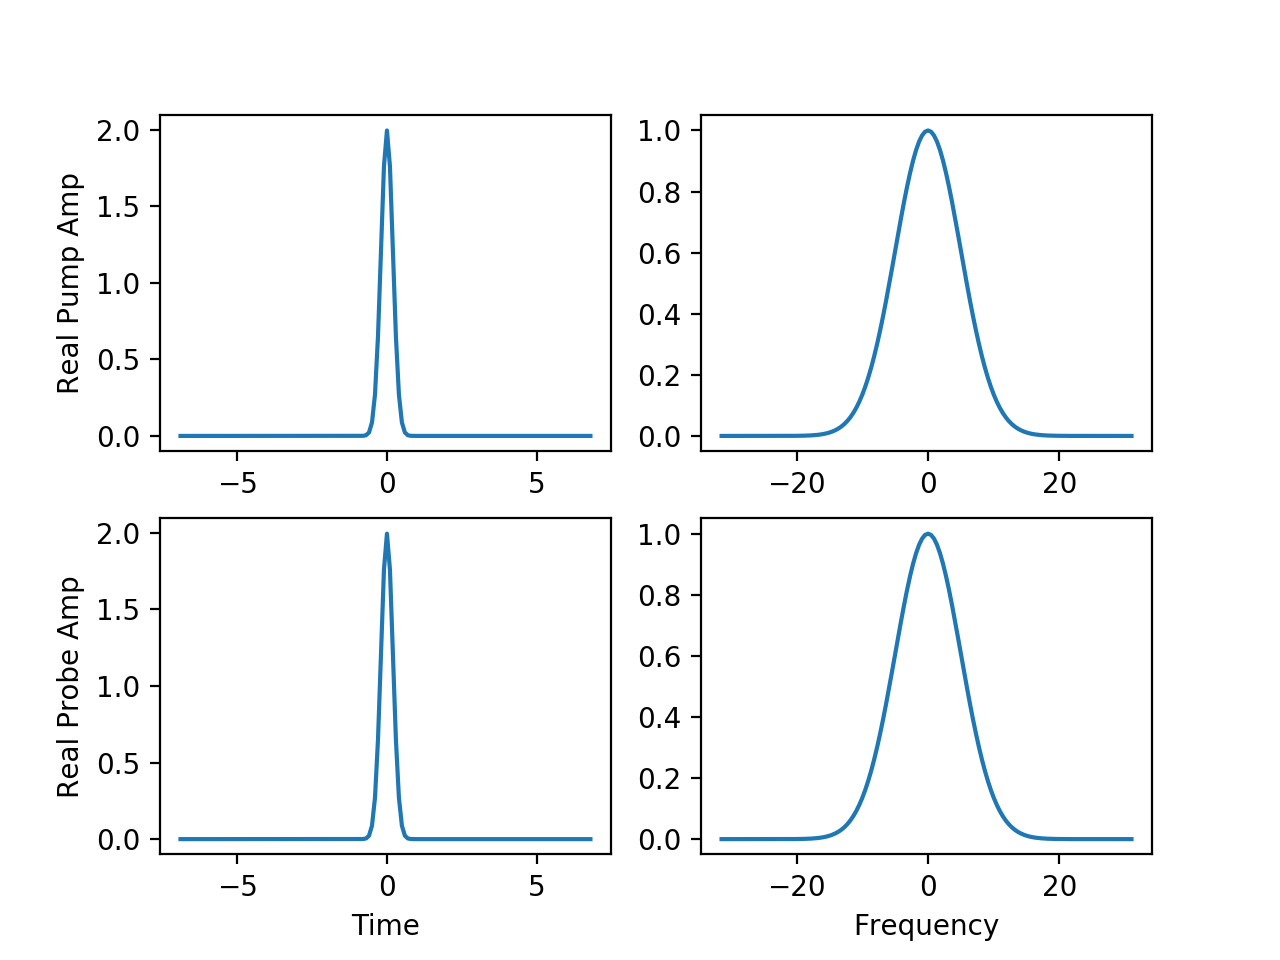

In [10]:
import TA_isotropic_average_example
reload(TA_isotropic_average_example)
ta_iso = TA_isotropic_average_example.TransientAbsorptionIsotropicAverage(file_path,pol_seq,dt=dt)
ta_iso.set_pulse_shapes(pu,pr)

<IPython.core.display.Javascript object>


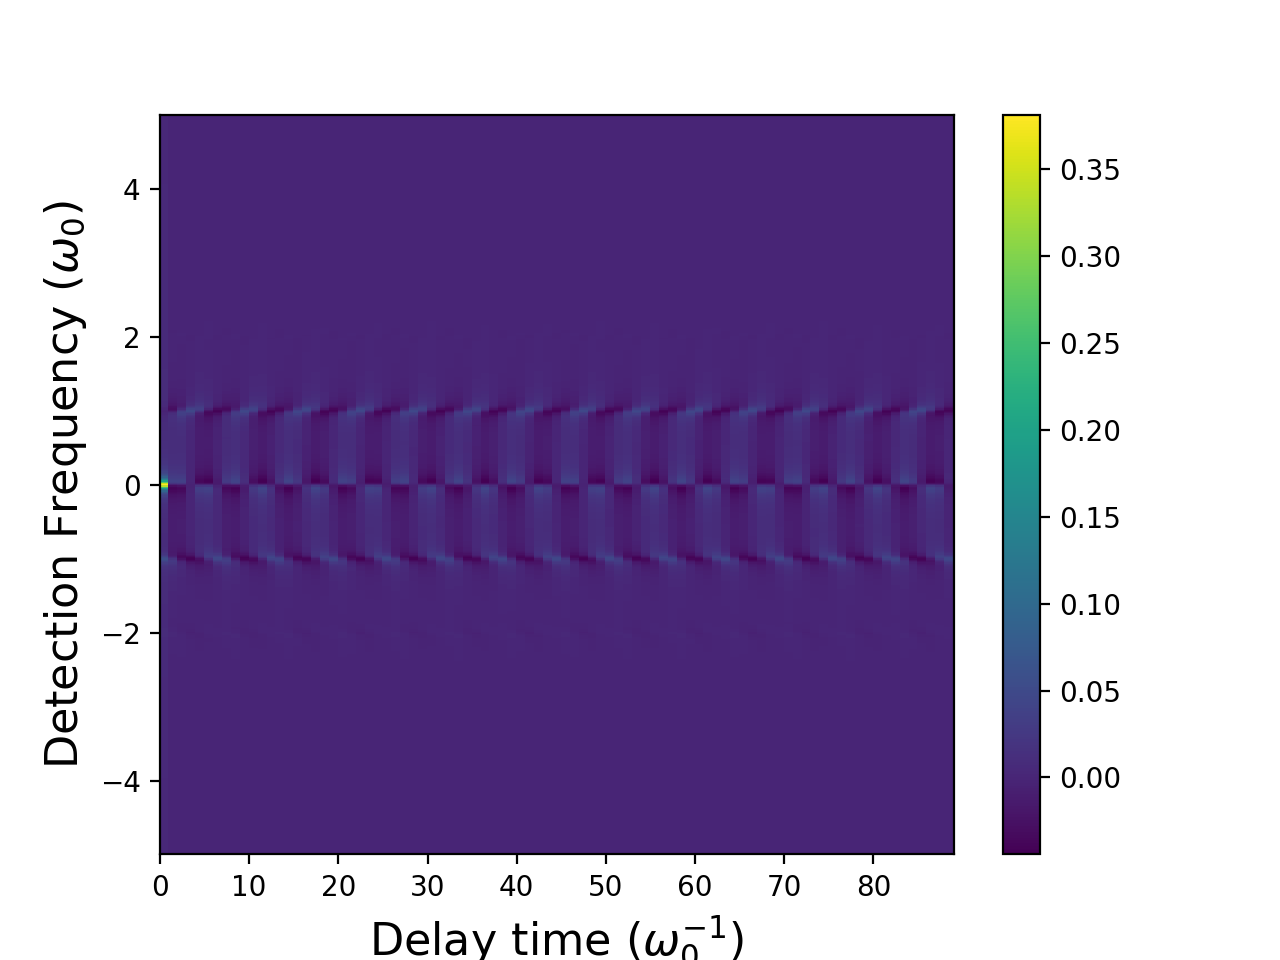

In [11]:
spectra_iso = ta_iso.calculate_spectra(delay_times)
ta_iso.save_pump_probe_spectra_vs_delay_time()
ta_iso.plot_pump_probe_spectra(frequency_range = [-5,5],subtract_DC=True,save_fig=True)

<IPython.core.display.Javascript object>


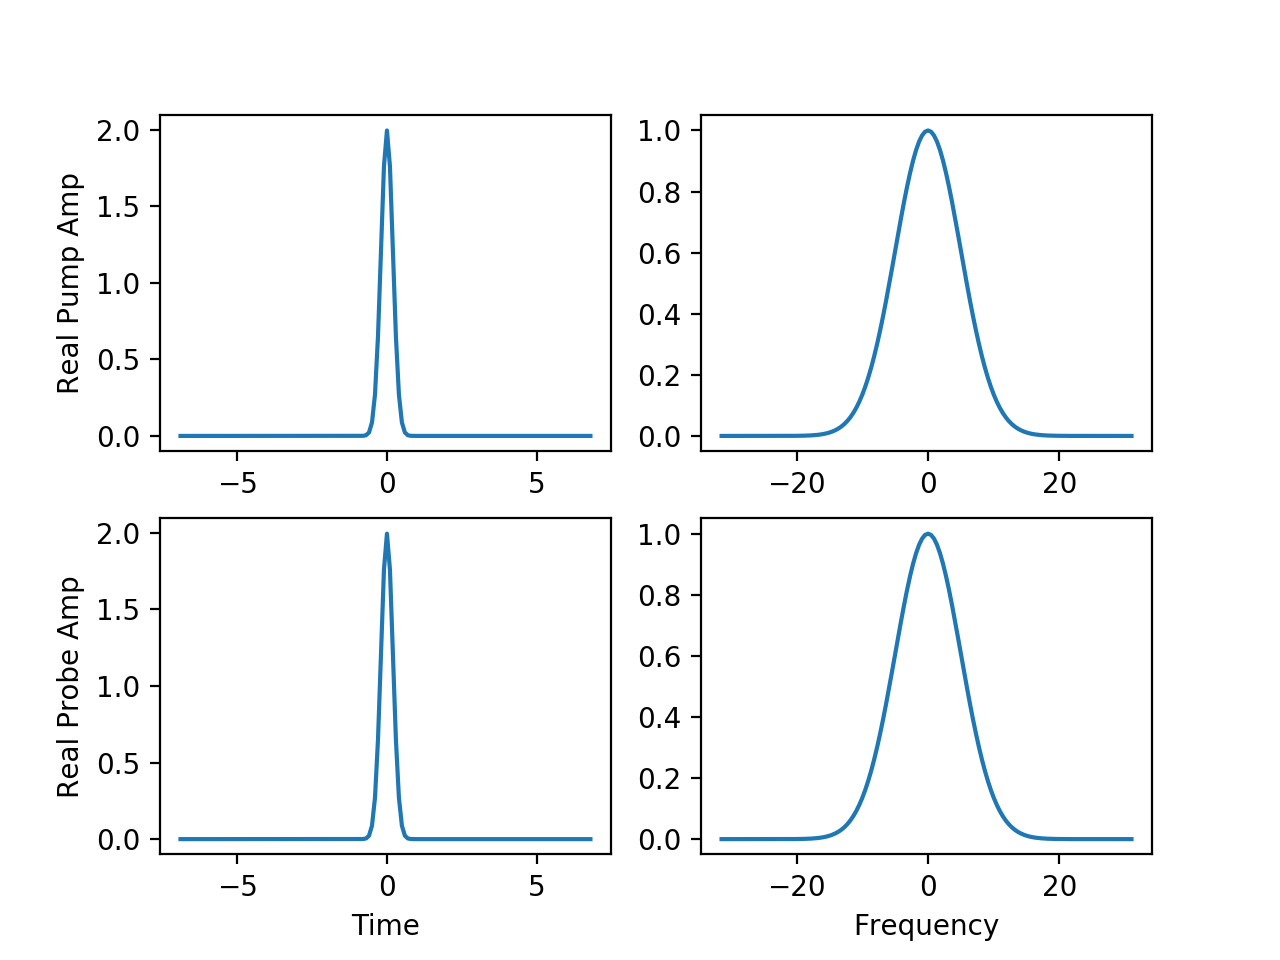

In [12]:
import TA_5th_order_example as TA5th
reload(TA5th)

# Initialize object with filepath to saved eigenvalues and dipole operator

ta5th = TA5th.TransientAbsorption5thOrder(file_path,dt=dt,initial_state=psi0_state,num_conv_points=M,
                                          total_num_time_points=total_t)

# As before, signal fields and polarization sequence must be set

pu = pump(ta5th.efield_t,pump_sigma) #Using above Gaussian field definition
pr = probe(ta5th.efield_t,probe_sigma) #Using above Gaussian field definition

# The class TransientAbsorption has a method for setting the four interaction fields given the pump shape and the
# probe shape

ta5th.set_pulse_shapes(pu,pr)

# The pump is polarized along the 'x' direcetion
# The probe is polarized along the same direcetion

ta5th.set_polarization_sequence(['x','x','x','x','x','x'])

<IPython.core.display.Javascript object>


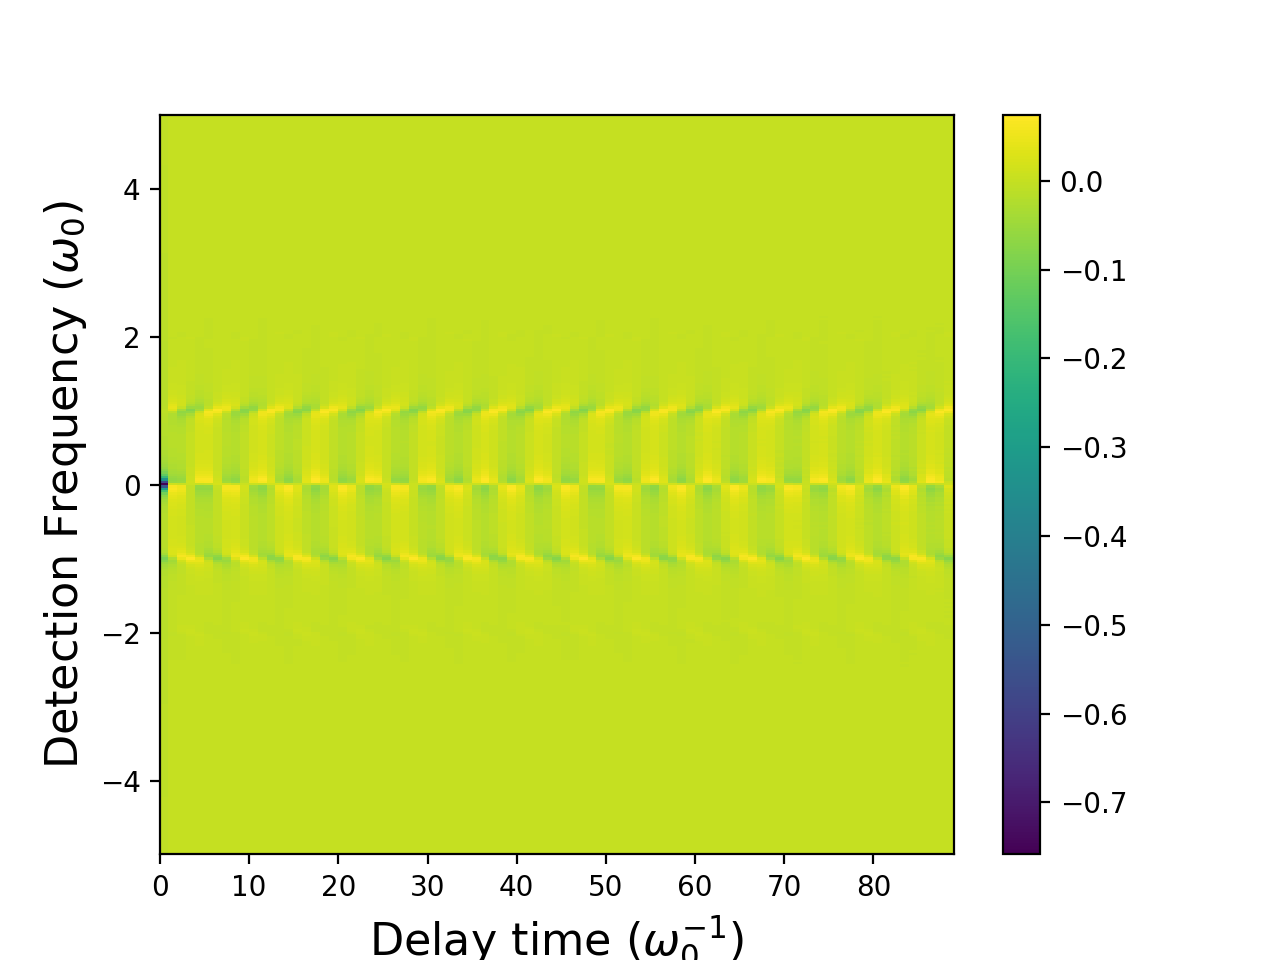

In [13]:
spectra5th = ta5th.calculate_pump_probe_spectra_vs_delay_time(delay_times)
ta5th.save_pump_probe_spectra_vs_delay_time()
ta5th.plot_pump_probe_spectra(frequency_range = [-5,5],subtract_DC=True)

<IPython.core.display.Javascript object>


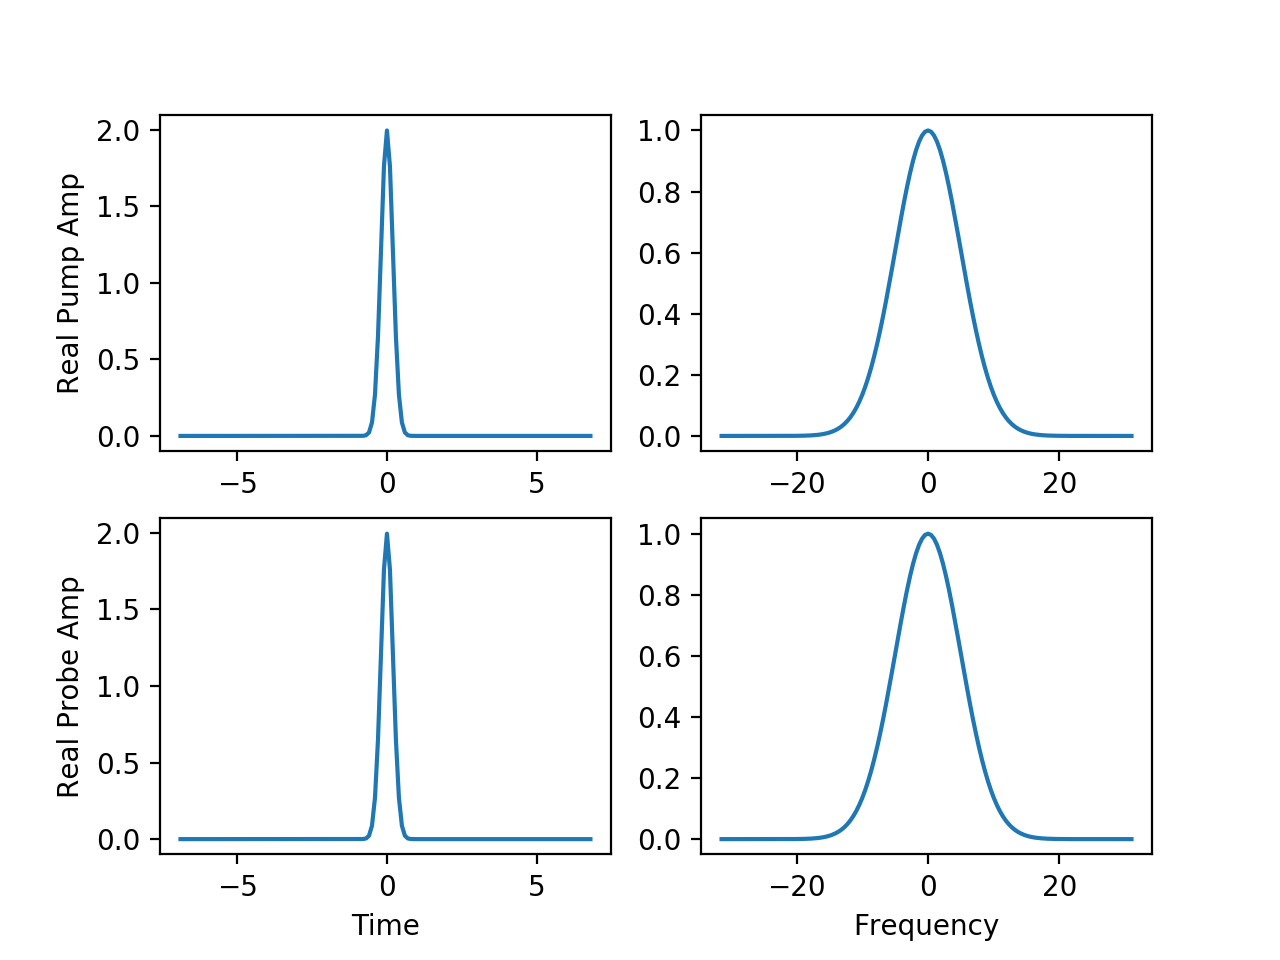

In [14]:
import TA_5th_order_isotropic_average_example as TA5th_iso

# Initialize object with filepath to saved eigenvalues and dipole operator

ta5th_iso = TA5th_iso.TransientAbsorption5thOrderIsotropicAverage(file_path,['x','x','x','x','x','x'],dt=dt,
                                                                  initial_state=psi0_state,num_conv_points=M,
                                                                  total_num_time_points=total_t)

# As before, signal fields and polarization sequence must be set

pu = pump(ta5th_iso.TA.efield_t,pump_sigma) #Using above Gaussian field definition
pr = probe(ta5th_iso.TA.efield_t,probe_sigma) #Using above Gaussian field definition

# The class TransientAbsorption has a method for setting the four interaction fields given the pump shape and the
# probe shape

ta5th_iso.set_pulse_shapes(pu,pr)

<IPython.core.display.Javascript object>


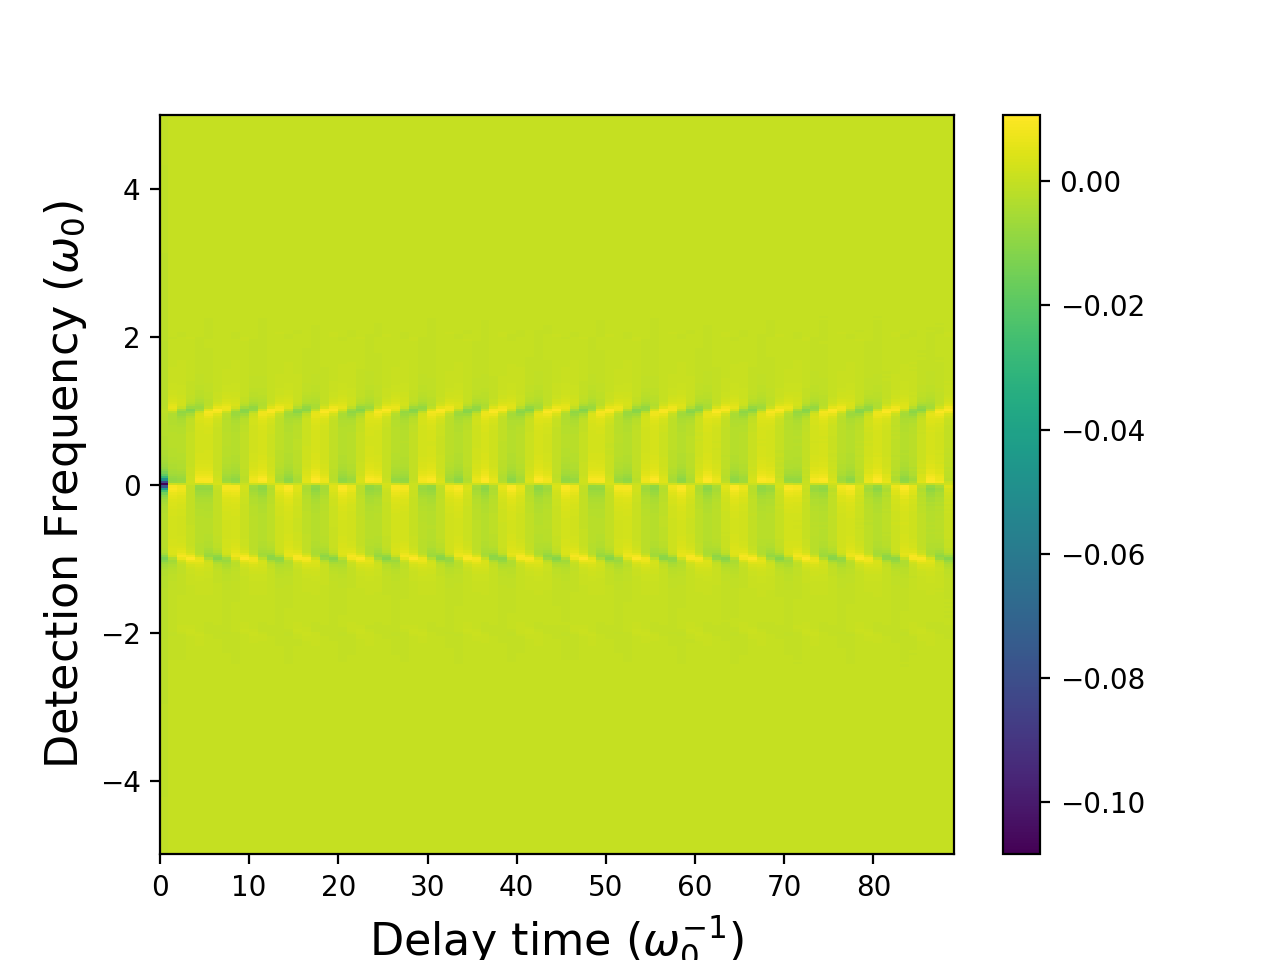

In [15]:
spectra5th_iso = ta5th_iso.calculate_spectra(delay_times)
ta5th_iso.save_pump_probe_spectra_vs_delay_time()
ta5th_iso.plot_pump_probe_spectra(frequency_range = [-5,5],subtract_DC=True)